<a href="https://colab.research.google.com/github/vasuiyen/CS230_Project/blob/main/LSTM_Prediction_Vehicle_Sensor_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Deep Learning - Predict Vehicle Control data Using Sequential Model
# This Model is run on google Colab
# code for Y prediction for all 3 features (ego vehcile features)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Activation
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from keras.layers import BatchNormalization
from keras.layers import Dropout
import os
import math
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [ ]:
def load_dataset(directory, nrows):
  data = []
  minrow = 35000
  files = os.listdir(directory)
  files.sort() # puts files in alpha-numeric order
  for file in files:
    data.append(pd.read_csv(os.path.join(directory,file),nrows=nrows))
  return data

# 3 Maneuver Dataset

In [ ]:
data = load_dataset("/content/drive/My Drive/Data/CS230 Project/99 Trials, 3 Maneuvers Data", 28915)

In [ ]:
def choose_feature(data, col_name_list):
  ret = []
  for row in data:
    ret.append(row[col_name_list])
  assert(len(ret) == 99)
  return ret

In [ ]:
col_name_list = ["xEgo_m_","yEgo_m_","yawEgo_rad_","uxEgo_m_s_","uyEgo_m_s_","yawRateEgo_rad_s_","axEgo_m_s_2_","ayEgo_m_s_2_","steeringWheel_rad_","throttlePedal_frac_","brakePedal_frac_"]
data = choose_feature(data, col_name_list) # (99, 28915, 11)
print(data[0].shape)
assert(data[0].shape[1] == len(col_name_list))

In [ ]:
sample_period = 20 # downsample 1 out of every 20 time steps, 1000 Hz (original) => 50 Hz (sampled)
window_size_input  = 50 # 1 second of data   
window_size_output = 1  # 0.02 second of data (next time step)  
train_rate = 0.8

X_1s = []
Y_1s = []
trial_idx = 0
X_1s_predict = [] # used for predicting controls over an entire trial
for trial in data:
  
  x_1s_predict = []
  data_sampled = trial.iloc[::sample_period, :] # downsampling 

  # creating sliding windows of data for input and output
  for t in range(window_size_input-1, data_sampled.shape[0]-1-window_size_output):
    
    x_window = data_sampled.iloc[t-(window_size_input-1):t+1, :]
    y_window = data_sampled.iloc[t+2:t+2+window_size_output, -3:]
    if(y_window.shape[0] <= (window_size_output-1)): # Handle the last window slice
       y_window = data_sampled.iloc[t+1-(window_size_output-1):t+2+(window_size_output-1), -3:]

    X_1s.append(x_window)
    Y_1s.append(y_window)

    x_1s_predict.append(x_window) # keeping data for each trial separate in X_1s_predict list

  X_1s_predict.append(x_1s_predict)
  trial_idx += 1

# note, using iloc above to index pandas dataframe as described here: 
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iloc.html  

assert(len(X_1s) == len(Y_1s))
num_total_samples = len(X_1s)

# https://stackoverflow.com/questions/11765061/better-way-to-shuffle-two-related-lists
X_1s_shuffled, Y_1s_shuffled = shuffle(X_1s, Y_1s) 

X_train = X_1s_shuffled[0:int(train_rate*num_total_samples)]
Y_train = Y_1s_shuffled[0:int(train_rate*num_total_samples)]
X_test = X_1s_shuffled[int(train_rate*num_total_samples):]
Y_test = Y_1s_shuffled[int(train_rate*num_total_samples):]
assert(len(X_train)+len(X_test) == num_total_samples)
assert(len(Y_train)+len(Y_test) == num_total_samples)
print(len(X_train), len(X_train), x_window.shape, y_window.shape)

X_train = np.array(X_train).reshape(len(X_train), X_train[0].shape[0], X_train[0].shape[1])
X_test  = np.array(X_test).reshape(len(X_test), X_test[0].shape[0], X_test[0].shape[1])

Y_train = np.array(Y_train).reshape(len(Y_train), Y_train[0].shape[0], Y_train[0].shape[1])
Y_test  = np.array(Y_test).reshape(len(Y_test), Y_test[0].shape[0], Y_test[0].shape[1])

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

In [ ]:
model = keras.Sequential()
model.add(layers.LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]))) # (time_steps, features)
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dense(500, activation='relu'))
model.add(layers.RepeatVector(Y_train.shape[1]))
model.add(layers.LSTM(100, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(3)))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

In [ ]:
history = model.fit(X_train, Y_train, epochs=10, batch_size=256)

In [ ]:
model.evaluate(X_test, Y_test)

In [ ]:
# comparing predicted output to known output for a given test sample
test_sample = 10322 # choose a random sample out of m_test samples
x_test = X_test[test_sample, :, :].reshape(1, X_test.shape[1], X_test.shape[2])
y_test = Y_test[test_sample, :, :]
y_predict  = model.predict(x_test)
print(y_test)
print(y_predict)

In [ ]:
# plotting control input predictions at just the next time step vs time for a specific trial 
trial = 2 # select a trial here
X_1s_predict_array = np.array(X_1s_predict[trial]).reshape(len(X_1s_predict[trial]), 
                              X_1s_predict[trial][0].shape[0], X_1s_predict[trial][0].shape[1])
Y_replay = model.predict(X_1s_predict_array)

plt.plot(0.02 * np.arange(Y_replay.shape[0]-1), Y_replay[:-1, :, 0], label = 'RNN prediction')
plt.plot(0.02 * np.arange(Y_replay.shape[0]-1), X_1s_predict_array[1:, -1, 8], label = 'truth')
plt.legend()
plt.title('steering')
plt.xlabel('time [sec]') 
plt.ylabel('steering wheel angle [rad]')
plt.show()

plt.plot(0.02 * np.arange(Y_replay.shape[0]-1), Y_replay[:-1, :, 1], label = 'RNN prediction')
plt.plot(0.02 * np.arange(Y_replay.shape[0]-1), X_1s_predict_array[1:, -1, 9], label = 'truth')
plt.legend()
plt.title('throttle')
plt.xlabel('time [sec]') 
plt.ylabel('throttle pedal fraction')
plt.show()

plt.plot(0.02 * np.arange(Y_replay.shape[0]-1), Y_replay[:-1, :, 2], label = 'RNN prediction')
plt.plot(0.02 * np.arange(Y_replay.shape[0]-1), X_1s_predict_array[1:, -1, 10], label = 'truth')
plt.legend()
plt.title('brake')
plt.xlabel('time [sec]') 
plt.ylabel('brake pedal fraction')
plt.show()

# Highway driving dataset

In [ ]:
data = load_dataset("/content/drive/My Drive/CS230_Project/Highway Driving Data/data", 9001)
print(data[1].shape) # note that a few of the csv files have slightly fewer rows than 9000

(9000, 21)


In [ ]:
# note: this cell takes ~2-4 min to run on my laptop
window_size_input  = 50  # 1 second of data   
window_size_output = 250 # 5 seconds of data (next 5 sec of control inputs predicted)  
train_rate = 0.8

X_1s = []
Y_1s = []
trial_idx = 0
X_1s_predict = [] # used for predicting controls over an entire trial
for trial in data:
  
  x_1s_predict = []
  data_sampled = trial.iloc[:, 1:] # removing time column data

  # creating sliding windows of data for input and output
  for t in range(window_size_input-1, data_sampled.shape[0]-1-window_size_output):
    
    x_window = data_sampled.iloc[t-(window_size_input-1):t+1, :]
    y_window = data_sampled.iloc[t+2:t+2+window_size_output, -3:]
    if(y_window.shape[0] <= (window_size_output-1)): # Handle the last window slice
       y_window = data_sampled.iloc[t+1-(window_size_output-1):t+2+(window_size_output-1), -3:]

    X_1s.append(x_window)
    Y_1s.append(y_window)

    x_1s_predict.append(x_window) # keeping data for each trial separate in X_1s_predict list

  X_1s_predict.append(x_1s_predict)
  trial_idx += 1

# note, using iloc above to index pandas dataframe as described here: 
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iloc.html  

assert(len(X_1s) == len(Y_1s))
num_total_samples = len(X_1s)

# https://stackoverflow.com/questions/11765061/better-way-to-shuffle-two-related-lists
X_1s_shuffled, Y_1s_shuffled = shuffle(X_1s, Y_1s) 

X_train = X_1s_shuffled[0:int(train_rate*num_total_samples)]
Y_train = Y_1s_shuffled[0:int(train_rate*num_total_samples)]
X_test = X_1s_shuffled[int(train_rate*num_total_samples):]
Y_test = Y_1s_shuffled[int(train_rate*num_total_samples):]
assert(len(X_train)+len(X_test) == num_total_samples)
assert(len(Y_train)+len(Y_test) == num_total_samples)
print(len(X_train), len(Y_train), x_window.shape, y_window.shape)

X_train = np.array(X_train).reshape(len(X_train), X_train[0].shape[0], X_train[0].shape[1])
X_test  = np.array(X_test).reshape(len(X_test), X_test[0].shape[0], X_test[0].shape[1])

Y_train = np.array(Y_train).reshape(len(Y_train), Y_train[0].shape[0], Y_train[0].shape[1])
Y_test  = np.array(Y_test).reshape(len(Y_test), Y_test[0].shape[0], Y_test[0].shape[1])

368837 368837 (50, 20) (250, 3)


In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(368837, 50, 20)
(368837, 250, 3)
(92210, 50, 20)
(92210, 250, 3)


In [ ]:
model = keras.Sequential()
model.add(layers.LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]))) # (time_steps, features)
#model.add(BatchNormalization())
model.add(layers.Dense(500, activation='relu')) # can add extra dense layers to add more nonlinearity
#model.add(layers.Dropout(rate=0.8))
#model.add(layers.Dense(500, activation='relu'))
model.add(layers.RepeatVector(Y_train.shape[1]))
model.add(layers.LSTM(100, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(3)))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               48400     
_________________________________________________________________
dense (Dense)                (None, 500)               50500     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 250, 500)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 250, 100)          240400    
_________________________________________________________________
time_distributed (TimeDistri (None, 250, 3)            303       
Total params: 339,603
Trainable params: 339,603
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, Y_train, epochs=10, batch_size=256)

Epoch 1/10
1441/1441 [==============================] - 60s 38ms/step - loss: 0.0136 - accuracy: 0.7563
Epoch 2/10
1441/1441 [==============================] - 55s 38ms/step - loss: 0.0102 - accuracy: 0.7926
Epoch 3/10
1441/1441 [==============================] - 55s 38ms/step - loss: 0.0092 - accuracy: 0.8012
Epoch 4/10
1441/1441 [==============================] - 55s 38ms/step - loss: 0.0082 - accuracy: 0.8084
Epoch 5/10
1441/1441 [==============================] - 55s 38ms/step - loss: 0.0073 - accuracy: 0.8173
Epoch 6/10
1441/1441 [==============================] - 55s 38ms/step - loss: 0.0066 - accuracy: 0.8253
Epoch 7/10
1441/1441 [==============================] - 55s 38ms/step - loss: 0.0059 - accuracy: 0.8317
Epoch 8/10
1441/1441 [==============================] - 55s 38ms/step - loss: 0.0055 - accuracy: 0.8355
Epoch 9/10
1441/1441 [==============================] - 55s 38ms/step - loss: 0.0053 - accuracy: 0.8382
Epoch 10/10
1441/1441 [==============================] - 55s 38m

In [ ]:
model.evaluate(X_test, Y_test)

2882/2882 [==============================] - 24s 8ms/step - loss: 0.0050 - accuracy: 0.8409


[0.004971879534423351, 0.8408894538879395]

In [ ]:
model.save("/content/drive/My Drive/CS230_Project/Highway Driving Data/5_sec_predict.ckpt")

INFO:tensorflow:Assets written to: /content/drive/My Drive/CS230_Project/Highway Driving Data/5_sec_predict.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/CS230_Project/Highway Driving Data/5_sec_predict.ckpt/assets


In [ ]:
# comparing predicted output to known output for a given test sample
# NOTE: this is most useful when window_size_output > 1

test_sample = 1200 # choose a random sample out of m_test samples
x_test = X_test[test_sample, :, :].reshape(1, X_test.shape[1], X_test.shape[2])
y_test = Y_test[test_sample, :, :]
y_predict  = model.predict(x_test)
print(y_test)
print(y_predict)

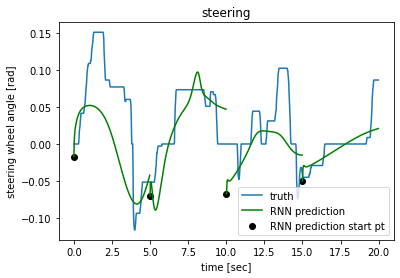

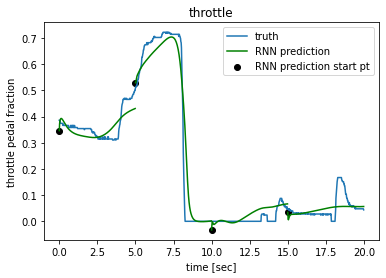

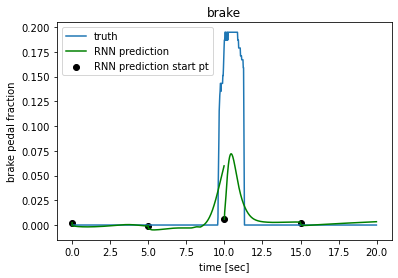

In [ ]:
# plotting full control input predictions at select time steps and the actual
# control inputs vs time for a specific trial 
# NOTE: use these plotting functions when window_size_output > 1

trial = 32 # select a trial here
X_1s_predict_array = np.array(X_1s_predict[trial]).reshape(len(X_1s_predict[trial]), 
                              X_1s_predict[trial][0].shape[0], X_1s_predict[trial][0].shape[1])
X_1s_predict_array = X_1s_predict_array[3200:4200, :, :] # shortening input data for plotting,
Y_replay = model.predict(X_1s_predict_array)             # can pick any window here 
Y_replay = Y_replay[::window_size_output, :, :] # only plotting every window_size_output predictions
Y_replay_start = Y_replay[:, 0, :]

plt.plot(0.02 * np.arange(X_1s_predict_array.shape[0]), X_1s_predict_array[:, -1, 17], label = 'truth')
for t in range(Y_replay.shape[0]):
  bound1 = window_size_output*t
  bound2 = window_size_output*(t+1)
  if t == 0: # legend just for first line
    plt.plot(0.02 * np.arange(bound1, bound2), 
             Y_replay[:, :, 0].reshape(Y_replay.shape[0]*Y_replay.shape[1])[bound1:bound2], 
             c = 'g', label = 'RNN prediction')
  else:
    plt.plot(0.02 * np.arange(bound1, bound2), 
             Y_replay[:, :, 0].reshape(Y_replay.shape[0]*Y_replay.shape[1])[bound1:bound2], 
             c = 'g')
plt.scatter((window_size_output / window_size_input) * np.arange(X_1s_predict_array.shape[0] / window_size_output), 
            Y_replay_start[:, 0], c = 'k', label = 'RNN prediction start pt')
plt.legend()
plt.title('steering')
plt.xlabel('time [sec]') 
plt.ylabel('steering wheel angle [rad]')
plt.show()

plt.plot(0.02 * np.arange(X_1s_predict_array.shape[0]), X_1s_predict_array[:, -1, 18], label = 'truth')
for t in range(Y_replay.shape[0]):
  bound1 = window_size_output*t
  bound2 = window_size_output*(t+1)
  if t == 0: # legend just for first line
    plt.plot(0.02 * np.arange(bound1, bound2), 
             Y_replay[:, :, 1].reshape(Y_replay.shape[0]*Y_replay.shape[1])[bound1:bound2], 
             c = 'g', label = 'RNN prediction')
  else:
    plt.plot(0.02 * np.arange(bound1, bound2), 
             Y_replay[:, :, 1].reshape(Y_replay.shape[0]*Y_replay.shape[1])[bound1:bound2], 
             c = 'g')
plt.scatter((window_size_output / window_size_input) * np.arange(X_1s_predict_array.shape[0] / window_size_output), 
            Y_replay_start[:, 1], c = 'k', label = 'RNN prediction start pt')
plt.legend()
plt.title('throttle')
plt.xlabel('time [sec]') 
plt.ylabel('throttle pedal fraction')
plt.show()

plt.plot(0.02 * np.arange(X_1s_predict_array.shape[0]), X_1s_predict_array[:, -1, 19], label = 'truth')
for t in range(Y_replay.shape[0]):
  bound1 = window_size_output*t
  bound2 = window_size_output*(t+1)
  if t == 0: # legend just for first line
    plt.plot(0.02 * np.arange(bound1, bound2), 
             Y_replay[:, :, 2].reshape(Y_replay.shape[0]*Y_replay.shape[1])[bound1:bound2], 
             c = 'g', label = 'RNN prediction')
  else:
    plt.plot(0.02 * np.arange(bound1, bound2), 
             Y_replay[:, :, 2].reshape(Y_replay.shape[0]*Y_replay.shape[1])[bound1:bound2], 
             c = 'g')
plt.scatter((window_size_output / window_size_input) * np.arange(X_1s_predict_array.shape[0] / window_size_output), 
            Y_replay_start[:, 2], c = 'k', label = 'RNN prediction start pt')
plt.legend()
plt.title('brake')
plt.xlabel('time [sec]') 
plt.ylabel('brake pedal fraction')
plt.show()

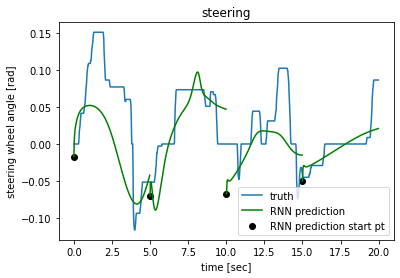

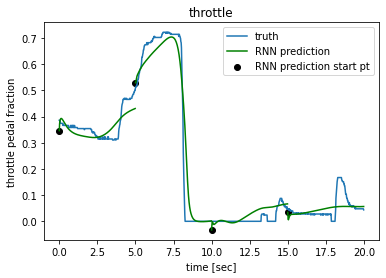

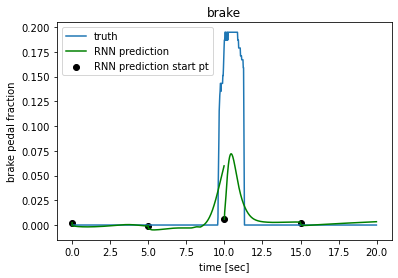

In [ ]:
# plotting full control input predictions at select time steps and the actual
# control inputs vs time for a specific trial 
# NOTE: use these plotting functions when window_size_output > 1

trial = 32 # select a trial here
X_1s_predict_array = np.array(X_1s_predict[trial]).reshape(len(X_1s_predict[trial]), 
                              X_1s_predict[trial][0].shape[0], X_1s_predict[trial][0].shape[1])
X_1s_predict_array = X_1s_predict_array[3200:4200, :, :] # shortening input data for plotting,
Y_replay = model.predict(X_1s_predict_array)             # can pick any window here 
Y_replay = Y_replay[::window_size_output, :, :] # only plotting every window_size_output predictions
Y_replay_start = Y_replay[:, 0, :]

plt.plot(0.02 * np.arange(X_1s_predict_array.shape[0]), X_1s_predict_array[:, -1, 17], label = 'truth')
for t in range(Y_replay.shape[0]):
  bound1 = window_size_output*t
  bound2 = window_size_output*(t+1)
  if t == 0: # legend just for first line
    plt.plot(0.02 * np.arange(bound1, bound2), 
             Y_replay[:, :, 0].reshape(Y_replay.shape[0]*Y_replay.shape[1])[bound1:bound2], 
             c = 'g', label = 'RNN prediction')
  else:
    plt.plot(0.02 * np.arange(bound1, bound2), 
             Y_replay[:, :, 0].reshape(Y_replay.shape[0]*Y_replay.shape[1])[bound1:bound2], 
             c = 'g')
plt.scatter((window_size_output / window_size_input) * np.arange(X_1s_predict_array.shape[0] / window_size_output), 
            Y_replay_start[:, 0], c = 'k', label = 'RNN prediction start pt')
plt.legend()
plt.title('steering')
plt.xlabel('time [sec]') 
plt.ylabel('steering wheel angle [rad]')
plt.show()

plt.plot(0.02 * np.arange(X_1s_predict_array.shape[0]), X_1s_predict_array[:, -1, 18], label = 'truth')
for t in range(Y_replay.shape[0]):
  bound1 = window_size_output*t
  bound2 = window_size_output*(t+1)
  if t == 0: # legend just for first line
    plt.plot(0.02 * np.arange(bound1, bound2), 
             Y_replay[:, :, 1].reshape(Y_replay.shape[0]*Y_replay.shape[1])[bound1:bound2], 
             c = 'g', label = 'RNN prediction')
  else:
    plt.plot(0.02 * np.arange(bound1, bound2), 
             Y_replay[:, :, 1].reshape(Y_replay.shape[0]*Y_replay.shape[1])[bound1:bound2], 
             c = 'g')
plt.scatter((window_size_output / window_size_input) * np.arange(X_1s_predict_array.shape[0] / window_size_output), 
            Y_replay_start[:, 1], c = 'k', label = 'RNN prediction start pt')
plt.legend()
plt.title('throttle')
plt.xlabel('time [sec]') 
plt.ylabel('throttle pedal fraction')
plt.show()

plt.plot(0.02 * np.arange(X_1s_predict_array.shape[0]), X_1s_predict_array[:, -1, 19], label = 'truth')
for t in range(Y_replay.shape[0]):
  bound1 = window_size_output*t
  bound2 = window_size_output*(t+1)
  if t == 0: # legend just for first line
    plt.plot(0.02 * np.arange(bound1, bound2), 
             Y_replay[:, :, 2].reshape(Y_replay.shape[0]*Y_replay.shape[1])[bound1:bound2], 
             c = 'g', label = 'RNN prediction')
  else:
    plt.plot(0.02 * np.arange(bound1, bound2), 
             Y_replay[:, :, 2].reshape(Y_replay.shape[0]*Y_replay.shape[1])[bound1:bound2], 
             c = 'g')
plt.scatter((window_size_output / window_size_input) * np.arange(X_1s_predict_array.shape[0] / window_size_output), 
            Y_replay_start[:, 2], c = 'k', label = 'RNN prediction start pt')
plt.legend()
plt.title('brake')
plt.xlabel('time [sec]') 
plt.ylabel('brake pedal fraction')
plt.show()

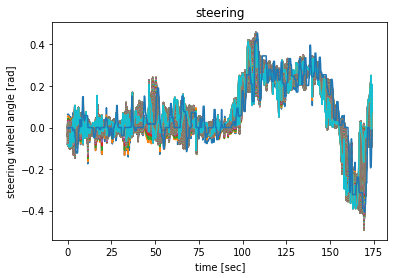

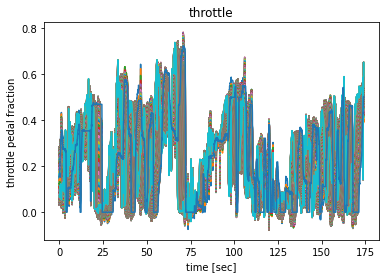

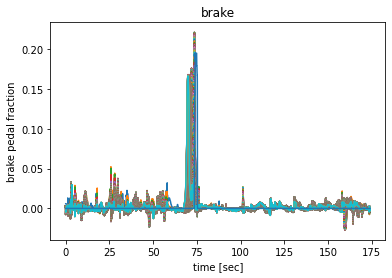

In [ ]:
# plotting control input prediction at next timestep for each time step and the 
# actual control inputs vs time for a specific trial 
# NOTE: use these plotting functions when window_size_output = 1

trial = 32 # select a trial here
X_1s_predict_array = np.array(X_1s_predict[trial]).reshape(len(X_1s_predict[trial]), 
                              X_1s_predict[trial][0].shape[0], X_1s_predict[trial][0].shape[1])
Y_replay = model.predict(X_1s_predict_array)

plt.plot(0.02 * np.arange(Y_replay.shape[0]-1), Y_replay[:-1, :, 0], label = 'RNN prediction')
plt.plot(0.02 * np.arange(Y_replay.shape[0]-1), X_1s_predict_array[1:, -1, 17], label = 'truth')
#plt.legend()
plt.title('steering')
plt.xlabel('time [sec]') 
plt.ylabel('steering wheel angle [rad]')
plt.show()

plt.plot(0.02 * np.arange(Y_replay.shape[0]-1), Y_replay[:-1, :, 1], label = 'RNN prediction')
plt.plot(0.02 * np.arange(Y_replay.shape[0]-1), X_1s_predict_array[1:, -1, 18], label = 'truth')
#plt.legend()
plt.title('throttle')
plt.xlabel('time [sec]') 
plt.ylabel('throttle pedal fraction')
plt.show()

plt.plot(0.02 * np.arange(Y_replay.shape[0]-1), Y_replay[:-1, :, 2], label = 'RNN prediction')
plt.plot(0.02 * np.arange(Y_replay.shape[0]-1), X_1s_predict_array[1:, -1, 19], label = 'truth')
#plt.legend()
plt.title('brake')
plt.xlabel('time [sec]') 
plt.ylabel('brake pedal fraction')
plt.show()